In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [ ]:
# !kaggle datasets download -d sadhliroomyprime/football-semantic-segmentation

In [ ]:
# import zipfile

# zip_ref = zipfile.ZipFile('/content/football-semantic-segmentation.zip', 'r')
# zip_ref.extractall('/content')
# zip_ref.close()

In [ ]:
# !pip install segmentation-models

import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [5]:
# !pip install git+https://github.com/qubvel/segmentation_models

In [6]:
import os
import numpy as np
import pandas as pd


# Data Visualization
import matplotlib.pyplot as plt

In [7]:
image_paths = '/content/images/'

all_img = os.listdir(image_paths)
original = []
masks = []
for one in all_img:
  if one.endswith('.jpg'):
    original.append(one)
  if one.endswith('fuse.png'):
    masks.append(one)

print(len(original))
print(len(masks))

100
100


In [8]:
original.sort()
masks.sort()

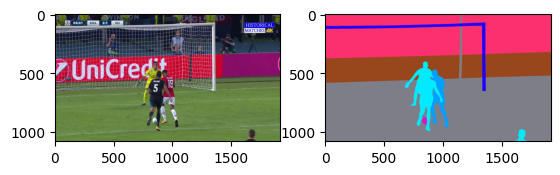

In [9]:
import cv2
import random

i = random.randint(0, len(original))
plt.subplot(121)
img = cv2.imread(image_paths + original[i])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

plt.subplot(122)
img2 = cv2.imread(image_paths + masks[i])
plt.imshow(img2)

In [10]:
img.shape

(1080, 1920, 3)

In [11]:

IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

In [12]:

# y = np.zeros((len(masks), IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype= np.float32)
# x = np.zeros((len(original), IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype= np.float32)

In [14]:
x = []

for file in original:
    n = original.index(file)
    path1 = os.path.join(image_paths, file)
    img1 = cv2.imread(path1, 1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img1 = cv2.resize(img1, (512, 512))
    x.append(img1)

In [15]:
x = np.array(x)

x.shape

(100, 512, 512, 3)

In [16]:
y = []

for file2 in masks:
    i = masks.index(file2)
    path2 = os.path.join(image_paths, file2)
    img2 = np.array(cv2.imread(path2, 1))
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    img2 = cv2.resize(img2, (512, 512))
    y.append(img2)

In [17]:
y = np.array(y)

y.shape

(100, 512, 512, 3)

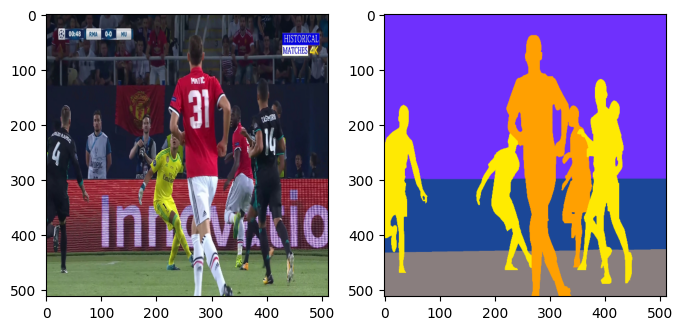

In [18]:
plt.figure(figsize = (8,5))
plt.subplot(121)
plt.imshow(x[5])
plt.subplot(122)
plt.imshow(y[5])
plt.show()

In [19]:
def rgb_to_2D_label(image):

    image_seg = np.zeros(image.shape, dtype= np.uint8)

    image_seg[np.all(image == np.array([255, 235, 0]), axis= -1)] = 0
    image_seg[np.all(image == np.array([0, 0 ,0]), axis= -1)] = 1
    image_seg[np.all(image == np.array([27 ,71, 151]), axis= -1)] = 2
    image_seg[np.all(image == np.array([111, 48, 253]), axis= -1)] = 3
    image_seg[np.all(image == np.array([137, 126, 126]), axis= -1)] = 4
    image_seg[np.all(image == np.array([201, 19, 223]), axis= -1)] = 5
    image_seg[np.all(image == np.array([238, 171, 171]), axis= -1)] = 6
    image_seg[np.all(image == np.array([254, 233, 3]), axis= -1)] = 7
    image_seg[np.all(image == np.array([255, 0, 29]), axis= -1)] = 8
    image_seg[np.all(image == np.array([255, 159, 0]), axis= -1)] = 9
    image_seg[np.all(image == np.array([255, 160, 1]), axis= -1)] = 10


    image_seg = image_seg[:,:,0]
    return image_seg

In [20]:
labels = []                             # create an empty list

for i in range(y.shape[0]):

    label = rgb_to_2D_label(y[i])

    labels.append(label)

labels = np.array(labels)

labels = np.expand_dims(labels, axis=3)

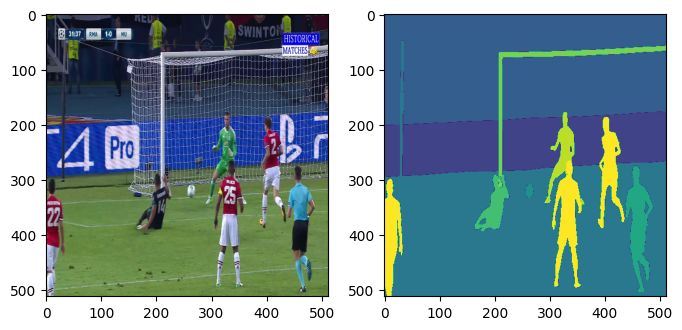

In [21]:
plt.figure(figsize = (8,5))
plt.subplot(121)
plt.imshow(x[9])
plt.subplot(122)
plt.imshow(labels[9][:,:,0])
plt.show()

In [22]:
n_classes = len(np.unique(labels))

from keras.utils import to_categorical                              ## One-hot-encoding

labels_cate = to_categorical(labels, num_classes= n_classes)

In [23]:
# Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, BatchNormalization, UpSampling2D, Concatenate, concatenate, Conv2DTranspose
from keras.models import Model

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
x_train, x_valid , y_train, y_valid = train_test_split(x, labels_cate, test_size= 0.15, random_state= 0)

In [25]:
print(x_train.shape)
print(len(x_train))

print(x_valid.shape)
print(len(x_valid))

print(y_train.shape)
print(len(y_train))

print(y_valid.shape)
print(len(y_valid))

(85, 512, 512, 3)
85
(15, 512, 512, 3)
15
(85, 512, 512, 11)
85
(15, 512, 512, 11)
15


In [26]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [27]:
X_train = preprocess_input(x_train)
X_valid = preprocess_input(x_valid)

In [28]:
input_shape= X_train.shape[1:]

input_shape

(512, 512, 3)

In [29]:
def unet_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Downsampling path
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Upsampling path
    up6 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(drop5)
    up6 = concatenate([up6, drop4])
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)          # Output layer with num_classes channels for multi-class segmentation

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [30]:
num_class = labels_cate.shape[-1]

num_class

11

In [31]:
model = unet_model(input_shape, num_class)

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [33]:
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [34]:
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer= optimizer, loss= sm.losses.bce_jaccard_loss, metrics= [sm.metrics.iou_score])

In [35]:
print(X_train.shape)

print(y_train.shape)

(85, 512, 512, 3)
(85, 512, 512, 11)


In [36]:
model.fit(X_train, y_train, batch_size= 10, epochs= 40, validation_data= (X_valid, y_valid))

Epoch 1/40
9/9 [==============================] - 40s 2s/step - loss: 3.1143 - iou_score: 0.0475 - val_loss: 1.2399 - val_iou_score: 0.0687
Epoch 2/40
9/9 [==============================] - 8s 923ms/step - loss: 1.2070 - iou_score: 0.0885 - val_loss: 1.0687 - val_iou_score: 0.1285
Epoch 3/40
9/9 [==============================] - 8s 935ms/step - loss: 1.0964 - iou_score: 0.1321 - val_loss: 1.0224 - val_iou_score: 0.1496
Epoch 4/40
9/9 [==============================] - 9s 951ms/step - loss: 1.0475 - iou_score: 0.1533 - val_loss: 0.9761 - val_iou_score: 0.1773
Epoch 5/40
9/9 [==============================] - 8s 944ms/step - loss: 1.0125 - iou_score: 0.1714 - val_loss: 0.9583 - val_iou_score: 0.1893
Epoch 6/40
9/9 [==============================] - 9s 959ms/step - loss: 0.9759 - iou_score: 0.1880 - val_loss: 0.9276 - val_iou_score: 0.2102
Epoch 7/40
9/9 [==============================] - 8s 932ms/step - loss: 0.9326 - iou_score: 0.2148 - val_loss: 0.9008 - val_iou_score: 0.2236
Epoch 8/

In [37]:
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 10s 10s/step - loss: 0.4275 - iou_score: 0.6063


[0.4274599850177765, 0.6062780022621155]

In [38]:
pred_train = model.predict(X_train, verbose=1)

pred_val = model.predict(X_valid, verbose= 1)

1/1 [==============================] - 0s 25ms/step


In [39]:
pred_val.shape

(15, 512, 512, 11)

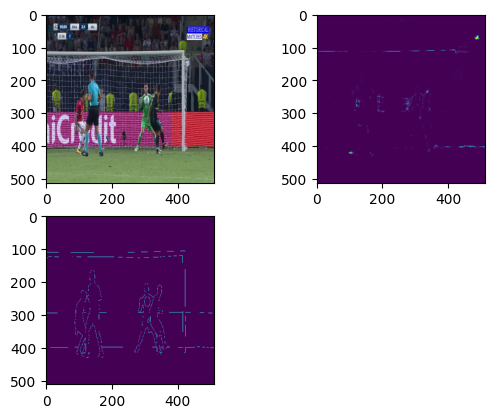

In [40]:
plt.subplot(221)
plt.imshow(X_train[6])

plt.subplot(222)
plt.imshow(pred_train[6][:,:,0])

plt.subplot(223)
plt.imshow(y_train[6][:,:,0])

In [41]:
import numpy as np

def convert_to_rgb(predictions):
    # Select the class with the highest probability for each pixel
    predicted_labels = np.argmax(predictions, axis=-1)

    # Define a reverse color map for each class
    colors = [
        [255, 235, 0],    # Class 0: Yellow
        [0, 0, 0],        # Class 1: Black
        [27, 71, 151],    # Class 2: Dark Blue
        [111, 48, 253],   # Class 3: Purple
        [137, 126, 126],  # Class 4: Gray
        [201, 19, 223],   # Class 5: Magenta
        [238, 171, 171],  # Class 6: Light Pink
        [254, 233, 3],    # Class 7: Yellowish
        [255, 0, 29],     # Class 8: Red
        [255, 159, 0],    # Class 9: Orange
        [255, 160, 1]     # Class 10: Orangeish
    ]

    # Initialize an empty array to store the RGB images
    rgb_images = []

    # Convert each predicted label to an RGB image
    for i in range(predicted_labels.shape[0]):
        
        # Initialize an empty RGB image
        rgb_image = np.zeros((predicted_labels.shape[1], predicted_labels.shape[2], 3), dtype=np.uint8)

        # Map each class to its corresponding RGB color
        for class_idx, color in enumerate(colors):
            mask = (predicted_labels[i] == class_idx)
            rgb_image[mask] = color

        # Append the RGB image to the list
        rgb_images.append(rgb_image)

    # Convert the list of RGB images to a NumPy array
    rgb_images = np.array(rgb_images)

    return rgb_images


In [42]:
# Assuming 'predictions' is your predicted segmentation masks with shape (15, 512, 512, 11)
rgb_images = convert_to_rgb(pred_val)

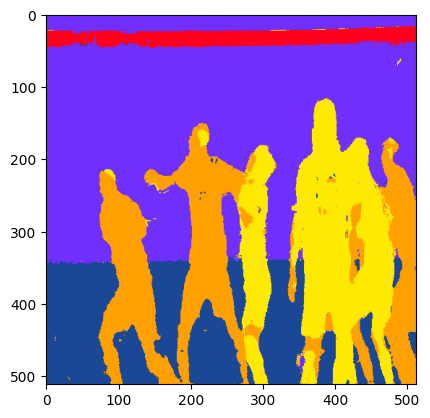

In [46]:
plt.imshow(rgb_images[4])

In [48]:
import numpy as np

def convert_to_rgb2(predictions):
    # Select the class with the highest probability for each pixel
    predicted_labels = np.argmax(predictions, axis=-1)

    # Define a reverse color map for each class
    colors = [
        [255, 235, 0],    # Class 0: Yellow
        [0, 0, 0],        # Class 1: Black
        [27, 71, 151],    # Class 2: Dark Blue
        [111, 48, 253],   # Class 3: Purple
        [137, 126, 126],  # Class 4: Gray
        [201, 19, 223],   # Class 5: Magenta
        [238, 171, 171],  # Class 6: Light Pink
        [254, 233, 3],    # Class 7: Yellowish
        [255, 0, 29],     # Class 8: Red
        [255, 159, 0],    # Class 9: Orange
        [255, 160, 1]     # Class 10: Orangeish
    ]

    # Initialize an empty array to store the RGB images
    rgb_images = []

    # Convert each predicted label to an RGB image
    for i in range(predicted_labels.shape[0]):
        # Initialize an empty RGB image
        rgb_image = np.zeros((predicted_labels.shape[1], predicted_labels.shape[2], 3), dtype=np.uint8)

        # Map each class to its corresponding RGB color
        for class_idx, color in enumerate(colors):
            mask = (predicted_labels[i] == class_idx)
            rgb_image[mask] = color

        # Append the RGB image to the list
        rgb_images.append(rgb_image)

    # Convert the list of RGB images to a NumPy array
    rgb_images2 = np.array(rgb_images)

    return rgb_images2


In [49]:
rgb_images2 = convert_to_rgb2(y_valid)

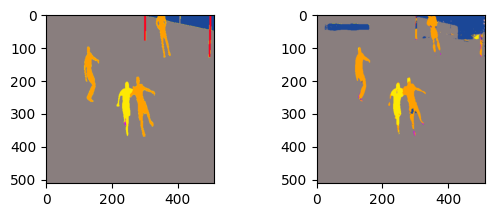

In [50]:
plt.subplot(221)
plt.imshow(rgb_images2[6])

plt.subplot(222)
plt.imshow(rgb_images[6])